In [52]:
import pandas as pd
import statistics
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from sklearn.preprocessing import MinMaxScaler

In [53]:
prediction_file_loc = "D:\\論文相關\\static analysis\\"
classifier_prediction = pd.read_pickle(prediction_file_loc+"classifier_emotion_predictions.pkl")
dict_prediction = pd.read_pickle(prediction_file_loc+"dict_emotion_predictions.pkl")
No_emo_prediction = pd.read_pickle(prediction_file_loc+"No_emotion_predictions.pkl")
alpha = 0.05 #Or whatever you want your alpha to be.


In [54]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

#定義show metric的func (給回歸數值用的)
def show_metrics(result_list ,cur_metric = mean_absolute_percentage_error, metric_name = "MAPE", if_emo = True):

    day_period = 0
    metric_all = 0
    counter = 0
    DF = {}
    for result  in result_list:
        text_len = 2
        day_period+=1
        print("\n")
        DF[day_period] ={}
        for cur_result in result:
            counter += 1
            cur_rmse = cur_metric(cur_result[1], cur_result[0])
            text_len+=1
            metric_all+=cur_rmse
            DF[day_period][text_len] = cur_rmse
            print(f"{metric_name} of {day_period}, text_len:{text_len} : {cur_rmse}")
    print(f"mean of all {metric_name}: ", metric_all/ counter, end= "\n")
    return pd.DataFrame(DF)
def RMSE(true, predict):
    return np.sqrt(mean_squared_error(true, predict))

def straight_diff(true, predict):
    return np.mean(predict-true)

def mean_abs_diff(true, predict):
    return np.mean(abs(predict-true))

In [55]:
# def 畫圖的function
def drow_regression_graph(result_list, graph_name):
    day_period = 1
    for result  in result_list:
        
        text_len = 3
        for cur_result in result:
            
            plt.figure()
            ax = plt.gca()
            #ax.set_xlim([xmin, xmax])
            ax.set_ylim([16800, 18500])
            plt.title(f"{graph_name}: {day_period}, text_len:{text_len}")
            plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  #用来正常显示中文标签
            plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
            plt.xlabel(u'預測股市天數')
            plt.ylabel(u'台股指數')

            plt.plot(cur_result[0], label='Predict')
            plt.plot([i for i in range(day_period, len(cur_result[1])+day_period)],cur_result[1], label='True')
            #plt.plot(training_data_emotion_ratio, label='emotion_ratio')
            plt.legend(loc='lower right')
            x0, xmax = plt.xlim()
            y0, ymax = plt.ylim()
            data_width = xmax - x0
            data_height = ymax - y0
            plt.grid(True)
            text_len +=1
        day_period+=1

In [56]:
#定義show metric的func (給acc, recall...等用的)
def get_metrics(result_list ,cur_metric = RMSE):
    metric_list = []

    for result  in result_list:
        for cur_result in result:
            cur_cal_metric = cur_metric(cur_result[1], cur_result[0])
            metric_list.append(cur_cal_metric)
            
    return metric_list

In [57]:
def get_up_down_pd(results, n =1):
    cur_pd = pd.DataFrame(results)
    cur_pd["return"] = (cur_pd[0]- cur_pd[0].shift(n))/cur_pd[0]
    cur_pd = cur_pd.fillna(0)
    cur_pd["up_down"] = cur_pd["return"].map(get_up_down)
    
    return cur_pd
def get_up_down(data, bounary = 0):
    if data>bounary:
        return 1
    else:
        return -1

def metric_up_down(trained_results, cur_metric = accuracy_score):
    DF = {}
    day_period = 1
    for result  in trained_results:
        text_len = 3
        DF[f"moving_avg_days "+str(day_period)] ={}
        for cur_result in result:
            predict_up_down = get_up_down_pd(cur_result[0])
            true_up_down = get_up_down_pd(cur_result[1])
            #print(f"moving_avg of {day_period} days and sentence_length limit of minimum {text_len} words")
            #print("acc:", accuracy_score(true_up_down["up_down"], predict_up_down["up_down"]))
            #print("recall:",recall_score(true_up_down["up_down"], predict_up_down["up_down"]))
            #print("precision:",precision_score(true_up_down["up_down"], predict_up_down["up_down"]))
            #print("F1:",f1_score(true_up_down["up_down"], predict_up_down["up_down"]))
            #print("\n")
            DF[f"moving_avg_days "+str(day_period)]["text_len "+ str(text_len)] = cur_metric(true_up_down["up_down"], predict_up_down["up_down"])
            text_len+=1
        day_period+=1
    return pd.DataFrame(DF)

# 重新做的部分

In [89]:
#self_label_dict_results_with_neu = pd.read_pickle(prediction_file_loc+"20220323_result_list_dict_self_label_with_neu.pkl")
#temp_dict = dict_results.copy()

#模型跑出來的結果 用pickle檔存好後 這邊讀來算統計量
self_label_dict_results = pd.read_pickle(prediction_file_loc+"20220405_result_list_self_label-5.pkl")
dict_results = pd.read_pickle(prediction_file_loc+"202200405_result_list_dict-4.pkl")
#dict_results = temp_dict
no_emo_results = pd.read_pickle(prediction_file_loc+"20220327_result_list_no_emotion-2.pkl")

#self label + dict label的 min text length = 0 (全部文本都丟下去)的情緒分數
classified_training_data = pd.read_pickle(f"D:\\論文相關\data\\classifier emotions\\classed_daily_emotion_categories_len_0_training_data.pkl")
#dict label的 min text length = 0 (全部文本都丟下去)的情緒分數
dict_training_data = pd.read_pickle(f"D:\\論文相關\\data\\emotion_data\\dict_emotions_len_0_training_data.pkl").loc["2020-04-20":]

#讀入不同min長度(3-6)的情緒分數
#這是分字數後的dict emotion list
dict_emo_list = pd.read_pickle("D:\\論文相關\\data\\emotion_data\\dict_emo_list.pickle") #最後一個是text limit = 0(全部資料集的emo)

#這是分字數後的self labeled +dict labeled emotion list
classified_emo_list = pd.read_pickle("D:\\論文相關\data\\classifier emotions\\classified_emotion_list_len_0.pkl")

for idx in range(len(dict_emo_list)):
    dict_emo_list[idx] = pd.DataFrame(dict_emo_list[idx]).T
    columns_to_drop = dict_emo_list[idx].columns
    dict_emo_list[idx]["pos"] = dict_emo_list[idx]["年報正面"]+  dict_emo_list[idx]["社媒正面"]
    dict_emo_list[idx]["neg"] = dict_emo_list[idx]["年報負面"]+  dict_emo_list[idx]["社媒負面"]
    
    dict_emo_list[idx]["pos_ratio"] = dict_emo_list[idx]["pos"] /(dict_emo_list[idx]["neg"]+dict_emo_list[idx]["pos"])
    dict_emo_list[idx]["neg_ratio"] = dict_emo_list[idx]["neg"] /(dict_emo_list[idx]["neg"]+dict_emo_list[idx]["pos"])
    dict_emo_list[idx] = dict_emo_list[idx].loc["2020-04-20":,:]
    dict_emo_list[idx] = dict_emo_list[idx].drop(columns_to_drop, axis = 1)

#把dict labeled的情緒加到self labeled上面
dict_classified_emo_list = []
for idx in range(len(classified_emo_list)):
    cur_classified = classified_emo_list[idx]
    cur_dict = dict_emo_list[idx]
    columns_to_drop = cur_classified.columns
    cur_classified["pos"] = cur_dict["pos"] + cur_classified["classified_pos"]
    cur_classified["neg"] = cur_dict["neg"] + cur_classified["classified_neg"]

    cur_classified["pos_ratio"] = cur_classified["pos"]/(cur_classified["pos"]+ cur_classified["neg"])
    cur_classified["neg_ratio"] = cur_classified["neg"]/(cur_classified["pos"]+ cur_classified["neg"])
    cur_classified = cur_classified.drop(columns_to_drop, axis = 1)
    dict_classified_emo_list.append(cur_classified)

dict_training_data = dict_emo_list[4]
dict_emo_list = dict_emo_list[:4]

In [59]:
for i in range(len(classified_emo_list)):
    #把字典分數加給self label (因為原本的檔案只有self label 要再給dict 的分數才是 self label+dict)
    classified_emo_list[i]["pos"] = dict_emo_list[i]["pos"] +classified_emo_list[i]["classified_pos"]
    classified_emo_list[i]["neg"] = dict_emo_list[i]["neg"] +classified_emo_list[i]["classified_neg"]
    
    #取實際上訓練使用的範圍
    classified_emo_list[i] = classified_emo_list[i].loc["2020-04-20":,"pos":]
    
    #算比例
    classified_emo_list[i]["pos_ratio"] = classified_emo_list[i]["pos"]/(classified_emo_list[i]["pos"]+ classified_emo_list[i]["neg"])
    classified_emo_list[i]["neg_ratio"] = classified_emo_list[i]["neg"]/(classified_emo_list[i]["pos"]+ classified_emo_list[i]["neg"])
    
    #取實際上訓練使用的範圍
    dict_emo_list[i] = dict_emo_list[i].loc["2020-04-20":,:]

In [60]:
classified_emo_list[0]

,pos,neg,pos_ratio,neg_ratio
2020-04-20,40,27,0.597015,0.402985
2020-04-21,163,90,0.644269,0.355731
2020-04-22,104,83,0.556150,0.443850
2020-04-23,181,64,0.738776,0.261224
2020-04-24,273,138,0.664234,0.335766
...,...,...,...,...
2021-12-24,1509,671,0.692202,0.307798
2021-12-25,1120,538,0.675513,0.324487
2021-12-26,802,288,0.735780,0.264220
2021-12-27,1118,652,0.631638,0.368362


In [61]:
dict_emo_list[0]

,pos,neg,pos_ratio,neg_ratio
2020-04-20,38,24,0.612903,0.387097
2020-04-21,144,75,0.657534,0.342466
2020-04-22,84,73,0.535032,0.464968
2020-04-23,170,47,0.783410,0.216590
2020-04-24,251,118,0.680217,0.319783
...,...,...,...,...
2021-12-24,1248,480,0.722222,0.277778
2021-12-25,990,413,0.705631,0.294369
2021-12-26,713,233,0.753700,0.246300
2021-12-27,930,499,0.650805,0.349195


In [62]:
#算兩兩不同字數間的ANOVA顯著性

self_dict_text_diff = {}
for i in range(1,len(classified_emo_list)):
    self_dict_text_diff[(i+2, i+3)] = {"pos":stats.f_oneway(classified_emo_list[i]["pos"], classified_emo_list[i-1]["pos"]), 
                                       "neg":stats.f_oneway(classified_emo_list[i]["neg"], classified_emo_list[i-1]["neg"])}

self_dict_text_diff = pd.DataFrame(self_dict_text_diff)
dict_text_diff = {}
for i in range(1,len(dict_emo_list)):
    dict_text_diff[(i+2, i+3)] = {"pos":stats.f_oneway(dict_emo_list[i]["pos"], dict_emo_list[i-1]["pos"]), 
                                       "neg":stats.f_oneway(dict_emo_list[i]["neg"], dict_emo_list[i-1]["neg"])}
dict_text_diff = pd.DataFrame(dict_text_diff)

In [63]:
dict_text_diff

,3,4,5
,4,5,6
pos,"(0.07389008215959698, 0.7858002814836331)","(0.9344462248829138, 0.3338996441096468)","(0.47252265921184444, 0.4919580819628838)"
neg,"(0.05421805591236914, 0.8159182782819623)","(0.20779224544628833, 0.6485835542930094)","(0.27401426470061085, 0.600745579909262)"


In [64]:
self_dict_text_diff

,3,4,5
,4,5,6
pos,"(0.11562524276443792, 0.7338864442406857)","(1.205035309336612, 0.27253174957545595)","(0.710995040849683, 0.39927709040196213)"
neg,"(0.09315402500334587, 0.7602565896902305)","(0.41907704280223684, 0.5175183489907083)","(0.5113831567491731, 0.4746759797337218)"


In [65]:
show_metrics(self_label_dict_results, cur_metric = r2_score, metric_name = "R2", if_emo = True)



R2 of 1, text_len:3 : 0.7172154731500783
R2 of 1, text_len:4 : 0.7199693103692892
R2 of 1, text_len:5 : 0.7215927743563371
R2 of 1, text_len:6 : 0.7276980636519566


R2 of 2, text_len:3 : 0.5905603099695538
R2 of 2, text_len:4 : 0.5900494166100273
R2 of 2, text_len:5 : 0.590320780200049
R2 of 2, text_len:6 : 0.5944538076722632


R2 of 3, text_len:3 : 0.16410216722991233
R2 of 3, text_len:4 : 0.16573504826746732
R2 of 3, text_len:5 : 0.17586547318207368
R2 of 3, text_len:6 : 0.1946521593378091
mean of all R2:  0.4960178986664014


,1,2,3
3,0.717215,0.590560,0.164102
4,0.719969,0.590049,0.165735
5,0.721593,0.590321,0.175865
6,0.727698,0.594454,0.194652


In [66]:
show_metrics(dict_results, cur_metric = r2_score, metric_name = "R2", if_emo = True)



R2 of 1, text_len:3 : 0.5349042184316967
R2 of 1, text_len:4 : 0.5361697343501824
R2 of 1, text_len:5 : 0.53760862835991
R2 of 1, text_len:6 : 0.540978921294087


R2 of 2, text_len:3 : 0.5152955946577961
R2 of 2, text_len:4 : 0.5180972102582402
R2 of 2, text_len:5 : 0.5321830761017179
R2 of 2, text_len:6 : 0.5425591174032175


R2 of 3, text_len:3 : 0.16200785760360759
R2 of 3, text_len:4 : 0.1631599877886053
R2 of 3, text_len:5 : 0.1687084617230229
R2 of 3, text_len:6 : 0.17474548177343552
mean of all R2:  0.4105348574787932


,1,2,3
3,0.534904,0.515296,0.162008
4,0.536170,0.518097,0.163160
5,0.537609,0.532183,0.168708
6,0.540979,0.542559,0.174745


In [67]:
show_metrics(no_emo_results, cur_metric = r2_score, metric_name = "R2", if_emo = True)



R2 of 1, text_len:3 : 0.7769308699558763
R2 of 1, text_len:4 : 0.7769308699558763
R2 of 1, text_len:5 : 0.7769308699558763
R2 of 1, text_len:6 : 0.7769308699558763


R2 of 2, text_len:3 : 0.7015040807036818
R2 of 2, text_len:4 : 0.7015040807036818
R2 of 2, text_len:5 : 0.7015040807036818
R2 of 2, text_len:6 : 0.7015040807036818


R2 of 3, text_len:3 : 0.4916668915685777
R2 of 3, text_len:4 : 0.4916668915685777
R2 of 3, text_len:5 : 0.4916668915685777
R2 of 3, text_len:6 : 0.4916668915685777
mean of all R2:  0.6567006140760453


,1,2,3
3,0.776931,0.701504,0.491667
4,0.776931,0.701504,0.491667
5,0.776931,0.701504,0.491667
6,0.776931,0.701504,0.491667


In [68]:
show_metrics(self_label_dict_results, cur_metric = RMSE, metric_name = "RMSE", if_emo = True)



RMSE of 1, text_len:3 : 136.34140885742988
RMSE of 1, text_len:4 : 135.67591874392247
RMSE of 1, text_len:5 : 135.2820598764433
RMSE of 1, text_len:6 : 133.79051361662118


RMSE of 2, text_len:3 : 157.74639382894028
RMSE of 2, text_len:4 : 157.8447800656142
RMSE of 2, text_len:5 : 157.79252935715803
RMSE of 2, text_len:6 : 156.99457085767955


RMSE of 3, text_len:3 : 216.06558632856542
RMSE of 3, text_len:4 : 215.8544469692194
RMSE of 3, text_len:5 : 214.5398909005265
RMSE of 3, text_len:6 : 212.08050563413505
mean of all RMSE:  169.16738375302128


,1,2,3
3,136.341409,157.746394,216.065586
4,135.675919,157.844780,215.854447
5,135.282060,157.792529,214.539891
6,133.790514,156.994571,212.080506


In [69]:
show_metrics(dict_results, cur_metric = RMSE, metric_name = "RMSE", if_emo = True)



RMSE of 1, text_len:3 : 174.85222230475205
RMSE of 1, text_len:4 : 174.61417563994831
RMSE of 1, text_len:5 : 174.34312125788102
RMSE of 1, text_len:6 : 173.70658038343782


RMSE of 2, text_len:3 : 171.6338535318561
RMSE of 2, text_len:4 : 171.1371085787085
RMSE of 2, text_len:5 : 168.61741786012723
RMSE of 2, text_len:6 : 166.73699028036648


RMSE of 3, text_len:3 : 216.3360889777424
RMSE of 3, text_len:4 : 216.18732083588796
RMSE of 3, text_len:5 : 215.46943893268747
RMSE of 3, text_len:6 : 214.68562029704714
mean of all RMSE:  186.5266615733702


,1,2,3
3,174.852222,171.633854,216.336089
4,174.614176,171.137109,216.187321
5,174.343121,168.617418,215.469439
6,173.706580,166.736990,214.685620


In [70]:
show_metrics(no_emo_results, cur_metric = RMSE, metric_name = "RMSE", if_emo = True)



RMSE of 1, text_len:3 : 121.09318242360789
RMSE of 1, text_len:4 : 121.09318242360789
RMSE of 1, text_len:5 : 121.09318242360789
RMSE of 1, text_len:6 : 121.09318242360789


RMSE of 2, text_len:3 : 134.68947778821973
RMSE of 2, text_len:4 : 134.68947778821973
RMSE of 2, text_len:5 : 134.68947778821973
RMSE of 2, text_len:6 : 134.68947778821973


RMSE of 3, text_len:3 : 168.4935184652133
RMSE of 3, text_len:4 : 168.4935184652133
RMSE of 3, text_len:5 : 168.4935184652133
RMSE of 3, text_len:6 : 168.4935184652133
mean of all RMSE:  141.425392892347


,1,2,3
3,121.093182,134.689478,168.493518
4,121.093182,134.689478,168.493518
5,121.093182,134.689478,168.493518
6,121.093182,134.689478,168.493518


In [71]:
#self+dict label的 acc
metric_up_down(self_label_dict_results)

,moving_avg_days 1,moving_avg_days 2,moving_avg_days 3
text_len 3,0.644068,0.603448,0.543860
text_len 4,0.644068,0.586207,0.543860
text_len 5,0.644068,0.586207,0.526316
text_len 6,0.661017,0.586207,0.526316


In [72]:
#self+dict label的 f1

metric_up_down(self_label_dict_results, cur_metric= f1_score)

,moving_avg_days 1,moving_avg_days 2,moving_avg_days 3
text_len 3,0.666667,0.634921,0.606061
text_len 4,0.666667,0.612903,0.606061
text_len 5,0.655738,0.612903,0.584615
text_len 6,0.677419,0.612903,0.584615


In [73]:
#dict label的 acc

metric_up_down(dict_results)

,moving_avg_days 1,moving_avg_days 2,moving_avg_days 3
text_len 3,0.644068,0.568966,0.508772
text_len 4,0.627119,0.551724,0.508772
text_len 5,0.644068,0.534483,0.491228
text_len 6,0.644068,0.534483,0.491228


In [74]:
#dict label的 f1

metric_up_down(dict_results, cur_metric= f1_score)

,moving_avg_days 1,moving_avg_days 2,moving_avg_days 3
text_len 3,0.655738,0.590164,0.562500
text_len 4,0.645161,0.580645,0.562500
text_len 5,0.666667,0.557377,0.539683
text_len 6,0.666667,0.557377,0.539683


In [75]:
#No emo的 acc

metric_up_down(no_emo_results)

,moving_avg_days 1,moving_avg_days 2,moving_avg_days 3
text_len 3,0.728814,0.568966,0.508772
text_len 4,0.728814,0.568966,0.508772
text_len 5,0.728814,0.568966,0.508772
text_len 6,0.728814,0.568966,0.508772


In [76]:
#No emo的 f1
metric_up_down(no_emo_results, cur_metric= f1_score)

,moving_avg_days 1,moving_avg_days 2,moving_avg_days 3
text_len 3,0.757576,0.603175,0.575758
text_len 4,0.757576,0.603175,0.575758
text_len 5,0.757576,0.603175,0.575758
text_len 6,0.757576,0.603175,0.575758


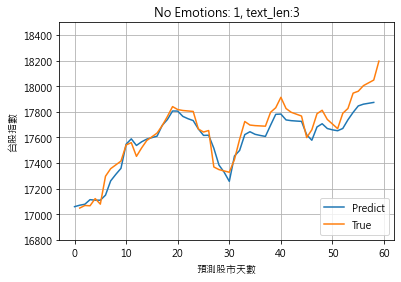

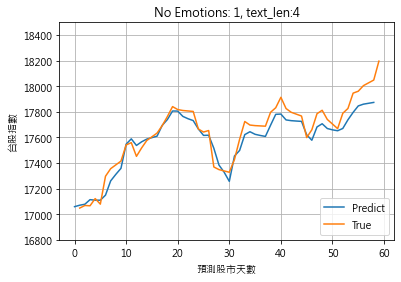

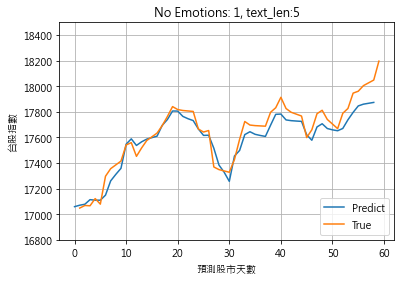

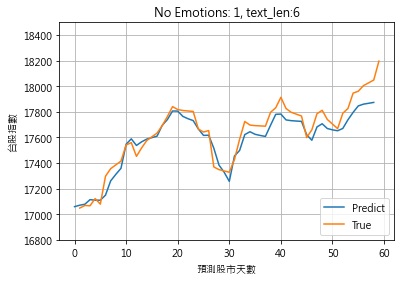

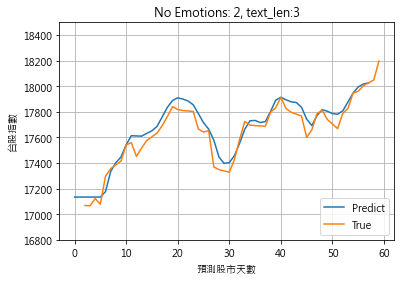

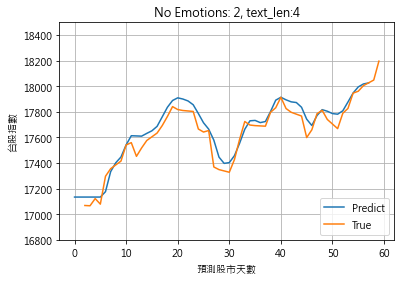

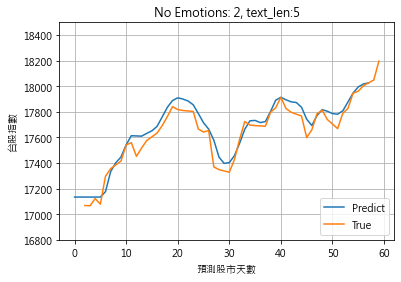

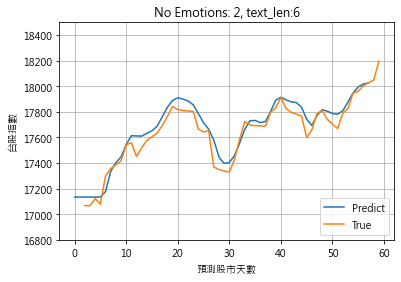

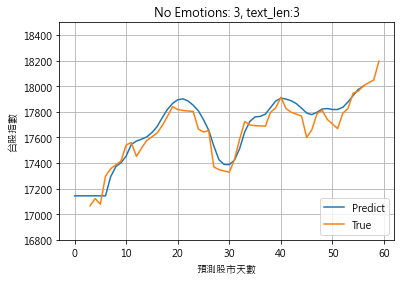

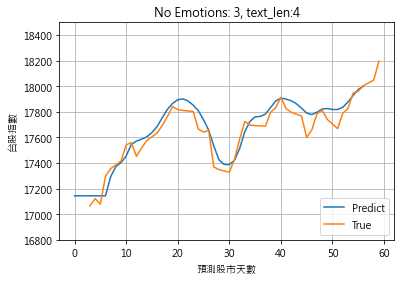

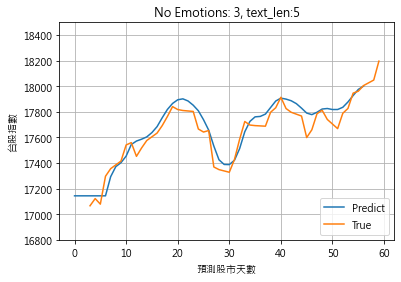

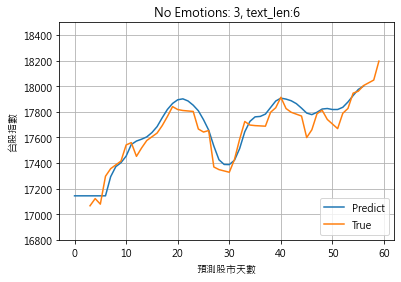

In [77]:
#畫不同天數不同字數限制的圖 No emotion
drow_regression_graph(no_emo_results, graph_name="No Emotions")

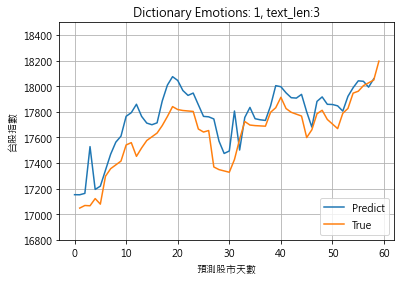

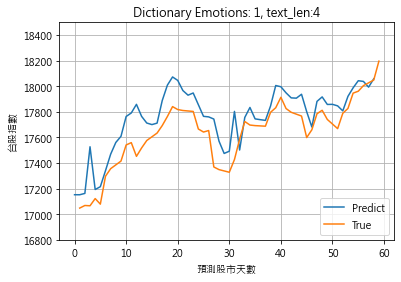

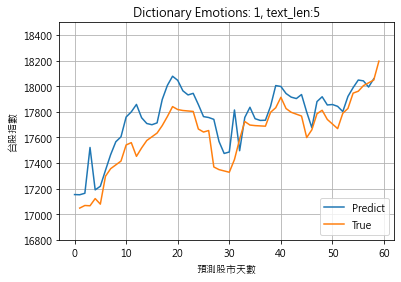

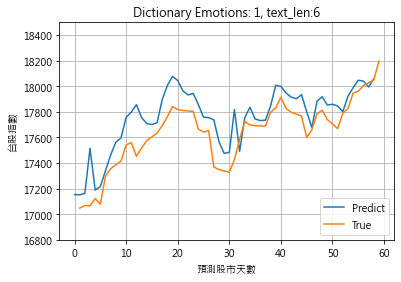

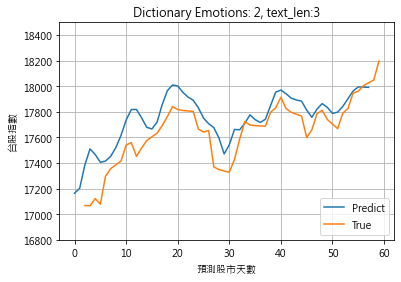

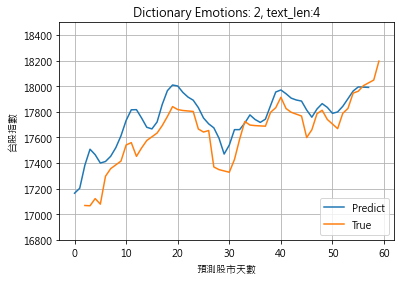

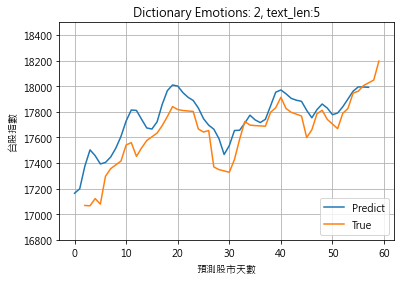

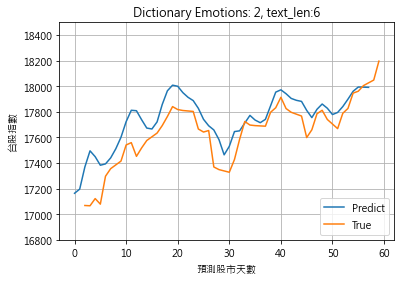

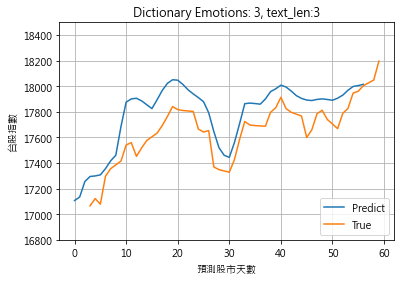

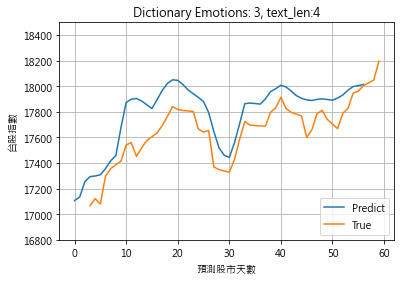

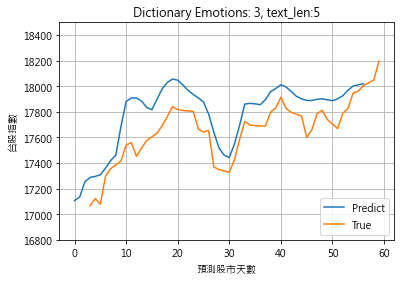

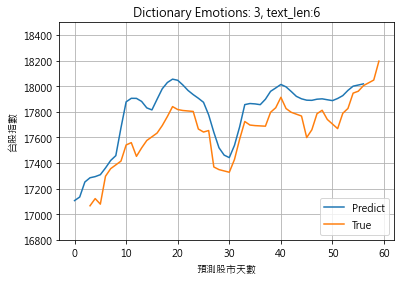

In [78]:
#畫不同天數不同字數限制的圖 dict

drow_regression_graph(dict_results, graph_name="Dictionary Emotions")

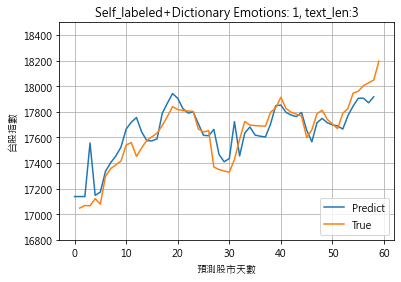

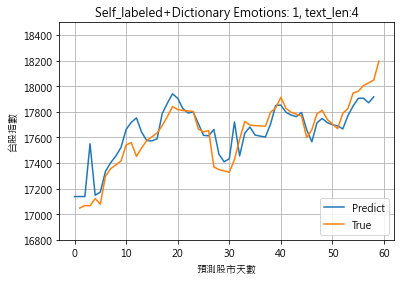

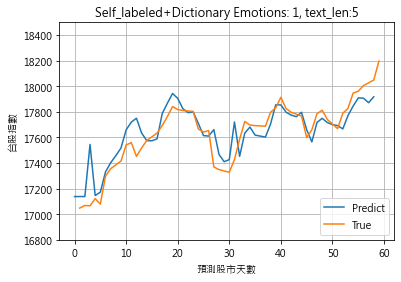

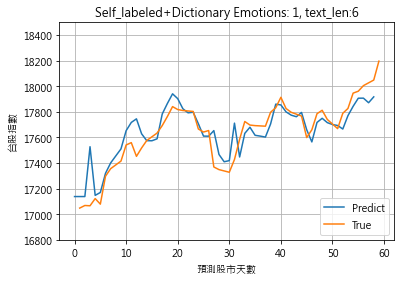

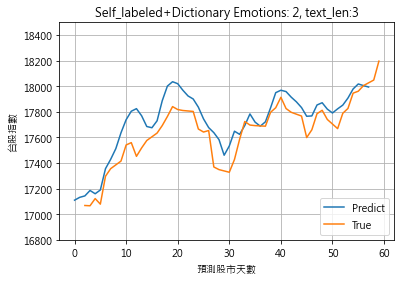

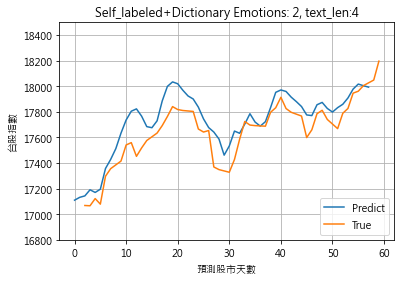

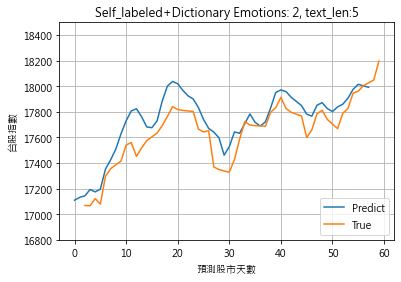

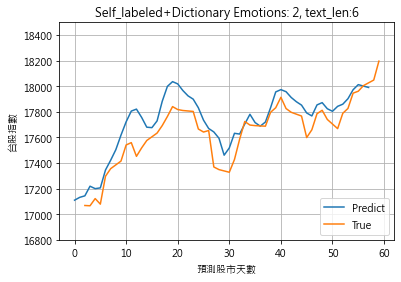

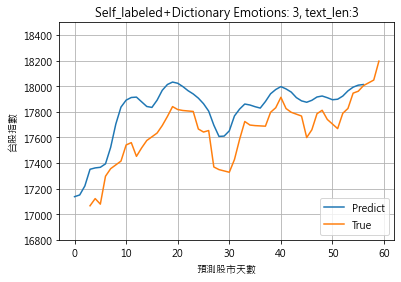

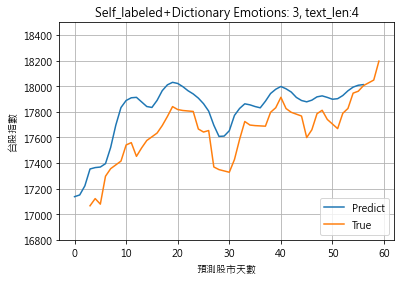

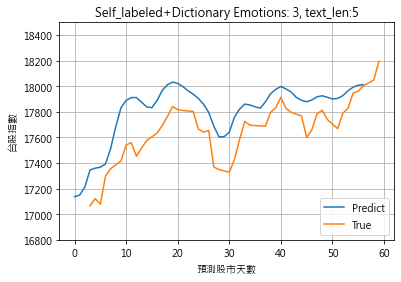

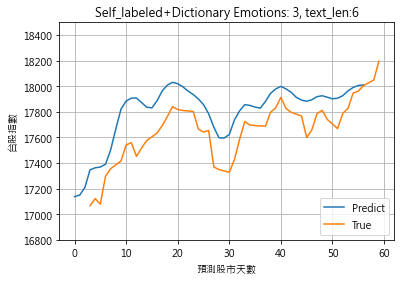

In [79]:
#畫不同天數不同字數限制的圖 self+dict
drow_regression_graph(self_label_dict_results, graph_name="Self_labeled+Dictionary Emotions")

In [80]:
#predict - true的mean (self+dict label)
show_metrics(self_label_dict_results, cur_metric = straight_diff, metric_name= "Straight difference")



Straight difference of 1, text_len:3 : 5.139019447033638
Straight difference of 1, text_len:4 : 4.842078239406519
Straight difference of 1, text_len:5 : 4.55784889618618
Straight difference of 1, text_len:6 : 2.570858694914994


Straight difference of 2, text_len:3 : 76.13083409482734
Straight difference of 2, text_len:4 : 77.86611830818941
Straight difference of 2, text_len:5 : 77.31988312499975
Straight difference of 2, text_len:6 : 76.8586088793101


Straight difference of 3, text_len:3 : 149.67082130921028
Straight difference of 3, text_len:4 : 150.1536543684208
Straight difference of 3, text_len:5 : 148.0327662105261
Straight difference of 3, text_len:6 : 144.97331582675415
mean of all Straight difference:  76.50965061664827


,1,2,3
3,5.139019,76.130834,149.670821
4,4.842078,77.866118,150.153654
5,4.557849,77.319883,148.032766
6,2.570859,76.858609,144.973316


In [81]:
#predict - true的mean (dict label)
show_metrics(dict_results, cur_metric = straight_diff, metric_name= "Straight difference")



Straight difference of 1, text_len:3 : 118.52570509322008
Straight difference of 1, text_len:4 : 118.22201070762686
Straight difference of 1, text_len:5 : 117.67996886440652
Straight difference of 1, text_len:6 : 116.89693125847431


Straight difference of 2, text_len:3 : 98.73441706896527
Straight difference of 2, text_len:4 : 98.38726593749975
Straight difference of 2, text_len:5 : 94.9707115193963
Straight difference of 2, text_len:6 : 92.74236426724113


Straight difference of 3, text_len:3 : 126.54441642982432
Straight difference of 3, text_len:4 : 126.26073358991204
Straight difference of 3, text_len:5 : 125.12428896271906
Straight difference of 3, text_len:6 : 124.03372564035064
mean of all Straight difference:  113.17687827830302


,1,2,3
3,118.525705,98.734417,126.544416
4,118.222011,98.387266,126.260734
5,117.679969,94.970712,125.124289
6,116.896931,92.742364,124.033726


In [82]:
#predict - true的mean (No emotion)
show_metrics(no_emo_results, cur_metric = straight_diff, metric_name= "Straight difference")



Straight difference of 1, text_len:3 : -64.35234045762738
Straight difference of 1, text_len:4 : -64.35234045762738
Straight difference of 1, text_len:5 : -64.35234045762738
Straight difference of 1, text_len:6 : -64.35234045762738


Straight difference of 2, text_len:3 : 12.594869655172166
Straight difference of 2, text_len:4 : 12.594869655172166
Straight difference of 2, text_len:5 : 12.594869655172166
Straight difference of 2, text_len:6 : 12.594869655172166


Straight difference of 3, text_len:3 : -7.4768623530704135
Straight difference of 3, text_len:4 : -7.4768623530704135
Straight difference of 3, text_len:5 : -7.4768623530704135
Straight difference of 3, text_len:6 : -7.4768623530704135
mean of all Straight difference:  -19.744777718508534


,1,2,3
3,-64.35234,12.59487,-7.476862
4,-64.35234,12.59487,-7.476862
5,-64.35234,12.59487,-7.476862
6,-64.35234,12.59487,-7.476862


# test if the difference is sigificant (if the predicted results are shifted)

In [83]:
# put all moving avg with 3 word len into list and substract by true val

true_val_of_IDX_1_day = no_emo_results[0][0][1]
true_val_of_IDX_2_day = no_emo_results[1][0][1]
true_val_of_IDX_3_day = no_emo_results[2][0][1]
true_val_list = [true_val_of_IDX_1_day, true_val_of_IDX_2_day, true_val_of_IDX_3_day]

difference_list =[]


#Test if there is siginificant diff in differences
#append different text len and moving avg
for i in range(3):
    no_emo_3_days = []
    dict_emo_3_days = []
    self_label_dict_emo_3_days = []
    for k in range(4):
        no_emo_3_days.append(no_emo_results[i][k][0]-true_val_list[i])
        dict_emo_3_days.append(dict_results[i][k][0]-true_val_list[i])
        self_label_dict_emo_3_days.append(self_label_dict_results[i][k][0]-true_val_list[i])
    difference_list.append([no_emo_3_days, dict_emo_3_days, self_label_dict_emo_3_days])

In [84]:
for i in range(3):
    print(f"moving avg of {i+1} day")
    for k in range(4):
        print(f"text length: {k+1}")
        print("No emotions F_val:", stats.shapiro(difference_list[i][0][k])[0], " P_val:", stats.shapiro(difference_list[i][0][k])[1])
        print("Dict_emo F_val:", stats.shapiro(difference_list[i][1][k])[0], " P_val:", stats.shapiro(difference_list[i][1][k])[1])
        print("Self_label_dict emotions F_val:", stats.shapiro(difference_list[i][2][k])[0], " P_val:", stats.shapiro(difference_list[i][2][k])[1])
        print("\b")
    print("\n")

moving avg of 1 day
text length: 1
No emotions F_val: 0.9723628759384155  P_val: 0.1983805149793625
Dict_emo F_val: 0.9814873933792114  P_val: 0.5061637759208679
Self_label_dict emotions F_val: 0.974242627620697  P_val: 0.24329528212547302

text length: 2
No emotions F_val: 0.9723628759384155  P_val: 0.1983805149793625
Dict_emo F_val: 0.9815303683280945  P_val: 0.5081605911254883
Self_label_dict emotions F_val: 0.9750123620033264  P_val: 0.2642141282558441

text length: 3
No emotions F_val: 0.9723628759384155  P_val: 0.1983805149793625
Dict_emo F_val: 0.9807660579681396  P_val: 0.4733467996120453
Self_label_dict emotions F_val: 0.9760915040969849  P_val: 0.2962072789669037

text length: 4
No emotions F_val: 0.9723628759384155  P_val: 0.1983805149793625
Dict_emo F_val: 0.9805619716644287  P_val: 0.4643065631389618
Self_label_dict emotions F_val: 0.9781827330589294  P_val: 0.3675914704799652



moving avg of 2 day
text length: 1
No emotions F_val: 0.9867194294929504  P_val: 0.7761805

In [85]:
for i in range(3):
    print(f"Moving AVG: {i+1} day")
    for k in range(4):
        print(f"Text length limit: {k+1}")
        
        No_emotions = difference_list[i][0][k].reshape(-1)
        Dict_emo = difference_list[i][1][k].reshape(-1)
        Self_label_dict  = difference_list[i][2][k].reshape(-1)
        print(stats.levene(No_emotions, Dict_emo, Self_label_dict, center = 'mean'))
    print("\n")

Moving AVG: 1 day
Text length limit: 1
LeveneResult(statistic=1.2005276473020923, pvalue=0.3035163112725068)
Text length limit: 2
LeveneResult(statistic=1.173340479272206, pvalue=0.3117671518617757)
Text length limit: 3
LeveneResult(statistic=1.1924132673126948, pvalue=0.3059554960196389)
Text length limit: 4
LeveneResult(statistic=1.1780756963584706, pvalue=0.3103139484384583)


Moving AVG: 2 day
Text length limit: 1
LeveneResult(statistic=0.3887557185380428, pvalue=0.6784974341312848)
Text length limit: 2
LeveneResult(statistic=0.36569069903379403, pvalue=0.6942585226172464)
Text length limit: 3
LeveneResult(statistic=0.3688827826066561, pvalue=0.6920553737517223)
Text length limit: 4
LeveneResult(statistic=0.37896750638269827, pvalue=0.6851413456016562)


Moving AVG: 3 day
Text length limit: 1
LeveneResult(statistic=0.5408561779012373, pvalue=0.5832599004747478)
Text length limit: 2
LeveneResult(statistic=0.5674148987325632, pvalue=0.5680720277485992)
Text length limit: 3
LeveneResu

In [86]:
#for i in range(3):
    #print(stats.f_oneway(no_emo_3_days[i].reshape(-1), dict_emo_3_days[i].reshape(-1), self_label_dict_emo_3_days[i].reshape(-1)))
    
for i in range(3):
    print(f"Moving AVG: {i+1}")
    for k in range(4):
        print(f"F test of Text length limit: {k+3}")
        
        No_emotions = difference_list[i][0][k].reshape(-1)
        Dict_emo = difference_list[i][1][k].reshape(-1)
        Self_label_dict  = difference_list[i][2][k].reshape(-1)
        print(stats.f_oneway(No_emotions, Dict_emo, Self_label_dict))
    print("\n")

Moving AVG: 1
F test of Text length limit: 3
F_onewayResult(statistic=32.509835200659175, pvalue=1.0093868516194944e-12)
F test of Text length limit: 4
F_onewayResult(statistic=32.54723061549264, pvalue=9.822832737521003e-13)
F test of Text length limit: 5
F_onewayResult(statistic=32.409193991217116, pvalue=1.0861486320457857e-12)
F test of Text length limit: 6
F_onewayResult(statistic=32.53473259290446, pvalue=9.912587422600268e-13)


Moving AVG: 2
F test of Text length limit: 3
F_onewayResult(statistic=6.007030370514156, pvalue=0.00301124670817538)
F test of Text length limit: 4
F_onewayResult(statistic=6.080383659118885, pvalue=0.002811852916104056)
F test of Text length limit: 5
F_onewayResult(statistic=5.711958880302962, pvalue=0.003968947739086433)
F test of Text length limit: 6
F_onewayResult(statistic=5.506947665137508, pvalue=0.004810928557388874)


Moving AVG: 3
F test of Text length limit: 3
F_onewayResult(statistic=14.500024969123553, pvalue=1.5516987838968883e-06)
F test o

In [87]:
#把資料轉成可以餵給multi comparison的形式
def get_muti_comparison_DF(No_emotions, Dict_emo, Self_label_dict, moving_avg, text_len):
    label_ori = ["No_emotions_days: ", "Dict_emotions_days:", "Self_labeled_dict_emotions_days:"]

    DF = []
    label = []
    
    DF.extend(list(No_emotions.reshape(-1)))
    for k in range(len(No_emotions)):
        label.append(label_ori[0]+str(moving_avg+1)+f" text_len:{text_len+3}")
        
    DF.extend(list(Dict_emo))
    for k in range(len(Dict_emo)):
        label.append(label_ori[1]+str(moving_avg+1)+f" text_len:{text_len+3}")
        
    DF.extend(list(Self_label_dict))
    for k in range(len(Self_label_dict)):
        label.append(label_ori[2]+str(moving_avg+1)+f" text_len:{text_len+3}")
    DF = pd.DataFrame(DF)
    DF["label"] = label
    DF.columns = ["Straight_Differences", "Label"]
    
    return DF

In [88]:

#multi comparison
for i in range(3):
    print(f"Moving AVG: {i+1}")
    for k in range(4):
        print(f"F test of Text length limit: {k+3}")
        
        No_emotions = difference_list[i][0][k].reshape(-1)
        Dict_emo = difference_list[i][1][k].reshape(-1)
        Self_label_dict  = difference_list[i][2][k].reshape(-1)

        DF = get_muti_comparison_DF(No_emotions, Dict_emo, Self_label_dict, moving_avg=i, text_len=k)
        
        mc = MultiComparison(DF["Straight_Differences"], DF['Label'])
        tkresult = mc.tukeyhsd()
        print(tkresult)
        print("\n"*2)
        cur_csv = pd.DataFrame(tkresult._results_table.data)
        cur_csv.to_csv(f"D:\\論文相關\\static analysis\\multicomparison\\multicomparison_Moving AVG_ {i+1}_of Text length limit_ {k+3}.csv")

Moving AVG: 1
F test of Text length limit: 3
                                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
             group1                                group2                     meandiff p-adj    lower    upper   reject
-----------------------------------------------------------------------------------------------------------------------
Dict_emotions_days:1 text_len:3               No_emotions_days: 1 text_len:3  -182.878  0.001 -237.0081 -128.748   True
Dict_emotions_days:1 text_len:3 Self_labeled_dict_emotions_days:1 text_len:3 -113.3867  0.001 -167.5167 -59.2567   True
 No_emotions_days: 1 text_len:3 Self_labeled_dict_emotions_days:1 text_len:3   69.4914 0.0078   15.3614 123.6214   True
-----------------------------------------------------------------------------------------------------------------------



F test of Text length limit: 4
                                  Multiple Comparison of Means - Tukey HSD, FWER=

----------------------------------------------------------------------------------------------------------------------



F test of Text length limit: 5
                                  Multiple Comparison of Means - Tukey HSD, FWER=0.05                                  
             group1                                group2                     meandiff p-adj    lower    upper   reject
-----------------------------------------------------------------------------------------------------------------------
Dict_emotions_days:3 text_len:5               No_emotions_days: 3 text_len:5 -132.6012  0.001 -207.0355 -58.1668   True
Dict_emotions_days:3 text_len:5 Self_labeled_dict_emotions_days:3 text_len:5   22.9085 0.7283  -51.5259  97.3429  False
 No_emotions_days: 3 text_len:5 Self_labeled_dict_emotions_days:3 text_len:5  155.5096  0.001   81.0752  229.944   True
-----------------------------------------------------------------------------------------------------------------------



F te